#### In this part we will be creating a ML model using random forests as a solver, grid search for tuning parameters and cross validation to add more precision.

### ML Task

#### Loading the data

Importing our libraires

In [26]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.metrics 
import seaborn as sns
import matplotlib.pyplot as plt

Importing and re-verifying our df

In [27]:
df = pd.read_csv("clean_Brain Tumour.csv")
df.head()

,Unnamed: 0,Class,Mean,Standard Deviation,Skewness,Kurtosis,Contrast,Homogeneity,Dissimilarity,Correlation
0,0,0,-0.515700,-0.033144,0.067855,-0.097267,-0.268050,0.404100,-0.121709,1.000713
1,1,0,-0.129018,0.365594,-0.150204,-0.175881,-0.585492,1.345457,-0.799181,1.264377
2,2,1,-0.375013,0.984680,0.374531,0.037048,-0.421010,-1.649391,0.693704,0.850636
3,3,1,-0.616481,0.660820,0.615188,0.160202,0.212525,-1.840334,1.622995,0.322041
4,4,0,-0.379529,0.208352,0.070489,-0.094103,0.429532,0.171115,1.154744,0.650854


In [28]:
#Defining the data and target variables
x=df.drop(["Unnamed: 0","Class"],axis=1)
y=df["Class"]

#### Creating the model

In [29]:
# spliting the data
x_train ,x_test ,y_train ,y_test=train_test_split(x,y,test_size=0.2,random_state=30)

In [30]:
print("Le nombre d'échantillon d'entrainement = ",x_train.shape)
print("Le nombre d'échantillon de test = ",x_test.shape)

Le nombre d'échantillon d'entrainement =  (3009, 8)
Le nombre d'échantillon de test =  (753, 8)


In [31]:
#In order to tune our hyper parameters we're gonna use a randomizedSearch cross validation which will
#evaluate our hyperparameters (some that we chose , we shouldn't tune them all due to computation time)
#and give us a certain range which we will use afterwards

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [33]:
#And now we will do a GridSearchCV

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [600, 1000, 1400, 1800]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [38]:
from sklearn.model_selection import cross_val_score,ShuffleSplit


rfc = RandomForestClassifier(n_estimators=1000,criterion="entropy",max_depth=50,bootstrap=False)
y_hat = rfc.fit(x_train,y_train)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores=cross_val_score(rfc,x_train,y_train,cv=cv)
print(scores.mean())

0.9765227021040974


We got an excellent result, and now we will try and predict the test set and see the results

In [39]:
yrfc = rfc.predict(x_test)
print("Accuracy : ",metrics.accuracy_score(y_test, yrfc))

Accuracy :  0.9840637450199203


In [40]:
print("Confusion Matric : \n")
x = pd.DataFrame(metrics.confusion_matrix(y_test, yrfc))
x

Confusion Matric : 



,0,1
0,419,3
1,9,322


<AxesSubplot:title={'center':'Confusion matrix'}>

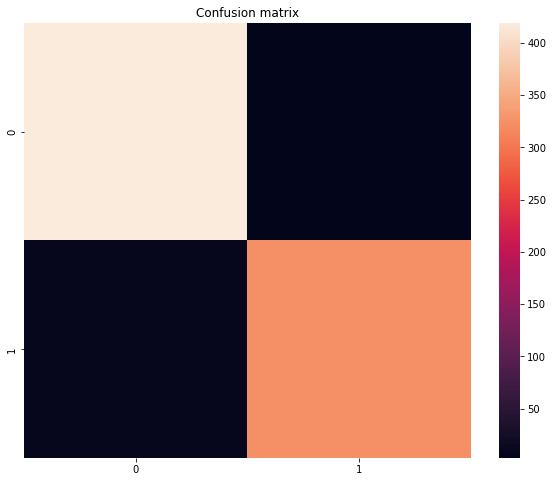

In [41]:
plt.figure(figsize =(10,8)),plt.title("Confusion matrix")
sns.heatmap(x)

We got excellent results on our test set with an accuarcy of 98%, which means our model was well built and our parameters were well tuned.
We will now be moving on to the next Task